# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Save-the-Data" data-toc-modified-id="Save-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save the Data</a></div><div class="lev1 toc-item"><a href="#Labeling" data-toc-modified-id="Labeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Labeling</a></div><div class="lev1 toc-item"><a href="#Compare" data-toc-modified-id="Compare-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [3]:
rawData = load_data('raw_data.json', 'abstract')

In [4]:
len(rawData)

21273

# Word Segmentation

In [5]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)|《(.*?)》|“(.{1,10})”')
re_replace = re.compile(u'[^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.]')

In [11]:
filename = "stopwords.txt"
stopWords = {w: None for w in open(filename).read().split()}

In [8]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub(' ', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        if s[i.start()] in [u'《', u'“']:
            result.extend([s[i.start()], s[i.start()+1:i.end()-1], s[i.end()-1]])
        else:
            result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def clean(s):
    """
    Clean data
    """
    for i in range(len(s)):
        if s[i] == ' ':
            s[i] = None
        if s[i] == '(':
            for j in range(i+1, len(s)):
                if s[j] == ')':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '（':
            for j in range(i+1, len(s)):
                if s[j] == '）':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '《':
            for j in range(i+1, len(s)):
                if s[j] == '》':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '%':
            if s[i-1] != None:
                s[i-1] = s[i-1]+'%'
            s[i] = None   
        if s[i] == '“' or s[i] == '”' or s[i] == '"':
            s[i] = None
        if s[i] == '於':
            s[i] = '于'
        if s[i] == '後':
            s[i] == '后'
    return [i for i in s if i != None]

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in [stopWords.get(i, i) for i in ws] if i != None]

In [44]:
rawData[0][14]

'发'

In [9]:
sentWords = [del_stop(clean(newcut(s))) for s in rawData]

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 1.033 seconds.
Prefix dict has been built succesfully.


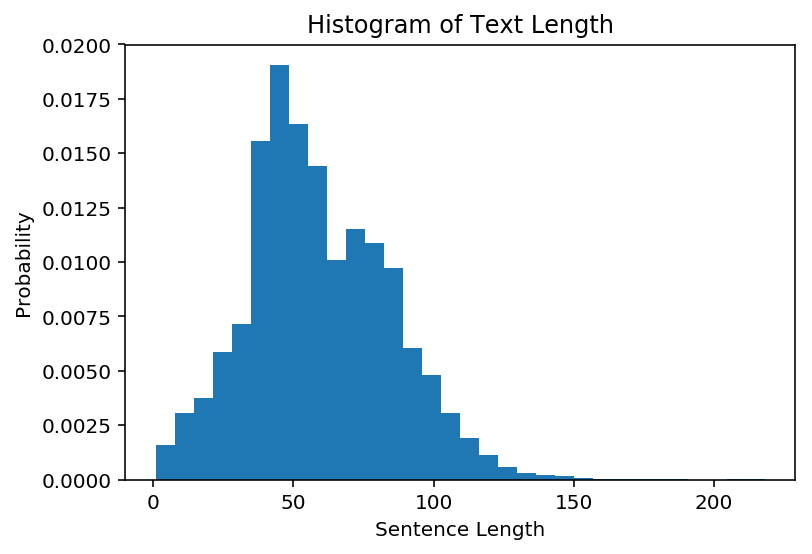

In [10]:
plt.hist([len(i) for i in sentWords], bins=32, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Save the Data

In [36]:
del_stop(clean(newcut('由于')))

['由于']

In [13]:
len([' '.join(i) for i in sentWords if len(i)>128])

140

In [14]:
max([len(i) for i in sentWords])

218

In [15]:
len(sentWords)

21273

In [58]:
#sentence = [rawData[j] for j, i in enumerate(sentWords) if len(i)>=16 and len(i)<=128]
sentence = load_data('do_mini.json', 'sentence')
label = load_data('do_mini.json', 'label')
sentence = [sentence[i] for i in range(1480) if label[i] == 0]

In [59]:
len(sentence)

1103

In [60]:
def write_to_file(content, name):
    with open(name, 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
        f.close()
        
def gen_data(data):
    for item in data:
        yield {
            'sentence': item,
            'label': 0
        }

In [61]:
for i in gen_data(sentence):
    write_to_file(i, 'do_mini.json')

In [49]:
!wc -l train_data.json

   20337 train_data.json


# Labeling

In [58]:
sample = load_data('sample_done.json', 'sentence')

In [60]:
for i in gen_data(sample):
    write_to_file(i, 'sample_do.json')

# Compare

In [24]:
lzn = load_data('sample_lzn.json', 'label')
lq = load_data('sample_lq.json', 'label')
sent = load_data('sample_do.json', 'sentence')

In [30]:
result = [i for i in range(100) if lzn[i] != lq[i]]
result

[11, 18, 34, 35, 39, 45, 46, 47, 48, 54, 55, 56, 60, 71, 72]

In [31]:
for i in result:
    print(i)
    print(sent[i])
    print(lzn[i])
    print(lq[i])
    print('--------------')

11
智通财经12日讯，和美医疗(01509)发布公告，就有关收购南通和美家51%股权，自该公告刊发以来，该公司收到一些投资者询问，并注意到部分媒体关于南通和美家执行董事兼经理林玉国身份的不实报道。该公司就此澄清，南通和美家现任执行董事兼经理林玉国为独立第3方。其与该公司非执行董事林玉国乃属同名同姓。南通和美家的林玉国与该公司主席兼总裁林玉明并无血缘关系。
0
1
--------------
18
如同一个技术好的设计师会找到两种产品的相似之处，并让用户发生不由自主地联想——200G的辣条和200G的苹果电脑，边吃辣条边玩《卫龙霸业》，“买辣条送装备、打怪升级送辣条”的画面就请自行脑补吧。正如36氪专栏作者夜叶所言，无论做手游或走苹果风，都是卫龙赶着消费升级的浪潮，为自己升级的举措，为的是跟上新时代年轻人的步伐。对90后而言，像食品类是否有实用价值或许并没那么重要，或说产品间差异性很小，这时趣味性作用更凸显。苹果风的卫龙辣条、最难喝的崂山白花蛇草水，都能成为他们追逐的对象，开心就好。吃根卫龙辣条，打着《卫龙霸业》的手游也一样，只要足够有意思，足够好玩，没什么不可以的。
1
0
--------------
34
快递龙头企业陆续上市，跟上资本的脚步之后，几家行业巨头又开始了整合之路。申通快递(002468)8月1日晚间公告称，以自有资金1.33亿元对快捷快递有限公司进行增资，增资完成后公司将取得快捷快递10%的股权，成为快捷快递第三大股东。
0
1
--------------
35
【南京银行接连被罚又当被告 “万亿银行”为何遭困局缠身】近年来，南京银行资产规模快速扩张，去年总资产突破万亿元，成功跻身银行业“万亿俱乐部”。然而，高速发展的同时，南京银行也暴露出了一系列的问题——不仅补充资本的压力日益突出，经营方式也面临着结构优化和转型的发展命题。今年以来，南京银行因违规问题接连受到监管机构处罚。近期，又被江苏柯菲平医药股份有限公司告上法庭，要求其赔偿柯菲平公司损失的3000万元及相关诉讼费用，再次将南京银行推至风口浪尖。（投资者报）
1
0
--------------
39
【机构介入 益生股份放量涨停】昨日，益生股份小幅低开之后快速翻红，股价震荡上行，上午便在涨停板附近徘徊，午后封板，收于21.55元，成交额为3.01亿元，环比明显放量。（中国证券报）
0
